This notebook compares the different vertical temperature and density setups. To know more about the different setups refer to the disklab library or my thesis. The physical set up of the disk has been done in the Disk_setup notebook

The physical inputs of the disk have been parametrised in this notebook in order to conduct some simple tests relating to the the change of these parameters

In [1]:
import numpy as np

import disklab
import matplotlib.pyplot as plt
from disklab.natconst import au
from disklab import radmc3d
from disklab.natconst import MS, LS, Mea, AU
import dsharp_helper as dh
from radmc3dPy import *
from imgcube import imagecube

import astropy.units as u
import astropy.constants as c  
from astropy.io import fits

import dsharp_opac as opacity

import os
import glob
import tempfile
from powerlaw_distri import get_powerlaw_dust_distribution
import copy

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [2]:
parameters = [2, 0.75, 0.5, 3, 0.5, 0.01, 0.0]
#parameters = [2, 0.75, 0.1, 3, 0.5, 0.01, 0.0]


In [3]:
#Dsharp helper being used to get some observed values of IMLup. Then imagecube is used to get the azimuthally averaged observed radial intensity profile

disk = 'IMLup'
fname = dh.get_datafile(disk)
PA = dh.sources.loc[disk]['PA']
inc = dh.sources.loc[disk]['inc']
distance = dh.sources.loc[disk]['distance [pc]']

data = imagecube(fname, clip=2.5)

x_arcsec, y, dy = data.radial_profile(inc=inc, PA=PA)


profile = (y * u.Jy / data.beam_area_str).cgs.value
profile_err = (dy * u.Jy / data.beam_area_str).cgs.value

In [4]:
# The different indices from the parameters list correspond to the following physical parameters
sigma_coeff = parameters[0]
sigma_exp   = parameters[1]
size_exp    = parameters[2]
amax_coeff  = parameters[3]
amax_exp    = parameters[4]        
d2g_coeff   = parameters[5]
d2g_exp     = parameters[6]

# temp_directory = tempfile.TemporaryDirectory()
#temp_path = temp_directory.name
# os.chdir(temp_directory.name)

# opac_name = 'DSHARP'  # choices: DSHARP, Draine

# define wave length and particle size grids

lam_opac = np.logspace(-5, 1, 200)
a_opac     = np.logspace(-5, -1, 20)

# define optical constants and material density

opac_fname = 'dustkappa_default'
diel_const, rho_s = opacity.get_dsharp_mix()

# call the Mie calculation & store the opacity in a npz file

opac_dict = opacity.get_opacities(
    a_opac, lam_opac, rho_s=rho_s, diel_const=diel_const, extrapolate_large_grains=True)
opacity.write_disklab_opacity(opac_fname, opac_dict)

# Mass, t and luminosity from Avenhaus 2018
mstar = 0.7 * MS
lstar = 1.56 * LS
tstar = 4266.00
mdust = 121 * Mea * 5
mdisk = mdust / 0.1
# flang = 0.05  # ??
zrmax = 1.0  # ??
nr = 200
rin = 0.1 * au
r_c = 100 * au  # ??
rout = 400 * au  # 400au from avenhaus paper  #DSHARP Huang 2018 says 290 au
alpha = 1e-3

opac_params = ['dustcomponents', {'method': 'simplemixing'}]

d = disklab.DiskRadialModel(mstar=mstar, lstar=lstar, tstar=tstar,
                            mdisk=mdisk, nr=nr, alpha=alpha, rin=rin, rout=rout)

d.make_disk_from_simplified_lbp(sigma_coeff, 3 * r_c, sigma_exp)

d2g = d2g_coeff * ((d.r/au)**d2g_exp)

# add N dust species

ngrains = 20
# agrains = np.array([5.e-5, 1.e-1])
agrains = np.logspace(-5, -1, ngrains)


a_max       = np.array([])
for rad_step in range(len(d.r)):
    a_max = np.append(a_max,np.max(agrains[agrains < (d.r[rad_step]/AU)**(-amax_exp) * amax_coeff]))

a, a_i, sig_da = get_powerlaw_dust_distribution(d.sigma/100, a_max, q=4-size_exp, na=ngrains, a0=1e-5, a1=1e-1)



for eps, agrain in zip(np.transpose(sig_da),  a):
    d.add_dust(agrain=agrain, xigrain=rho_s, dtg=d2g * eps)

# load the opacity from the previously calculated opacity table

for dust in d.dust:
    # dust.grain.load_standard_opacity('draine2003', 'astrosilicates', verbose=True)
    dust.grain.read_opacity(os.path.join(opac_fname + '.npz'))

# compute the mean opacities

d.meanopacitymodel = opac_params
d.compute_mean_opacity()

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
Mie ... Done!


In [5]:
#1+1D

d.mean_opacity_planck[7:]    = movingaverage(d.mean_opacity_planck,10)[7:]
d.mean_opacity_rosseland[7:] = movingaverage(d.mean_opacity_rosseland,10)[7:]

for iter in range(100):
    d.compute_hsurf()
    d.compute_flareindex()
    d.compute_flareangle_from_flareindex(inclrstar=True)
    d.compute_disktmid(keeptvisc=False)
    d.compute_cs_and_hp()

disk2d = disklab.Disk2D(disk=d, zrmax=zrmax,
                        meanopacitymodel=d.meanopacitymodel, nz=100)

# snippet vertstruc 1d1
for vert in disk2d.verts:
    vert.iterate_vertical_structure()
    vert.tgas = (vert.tgas**4 + 10**4)**(1/4)
    for dust in vert.dust:
        dust.compute_settling_mixing_equilibrium()

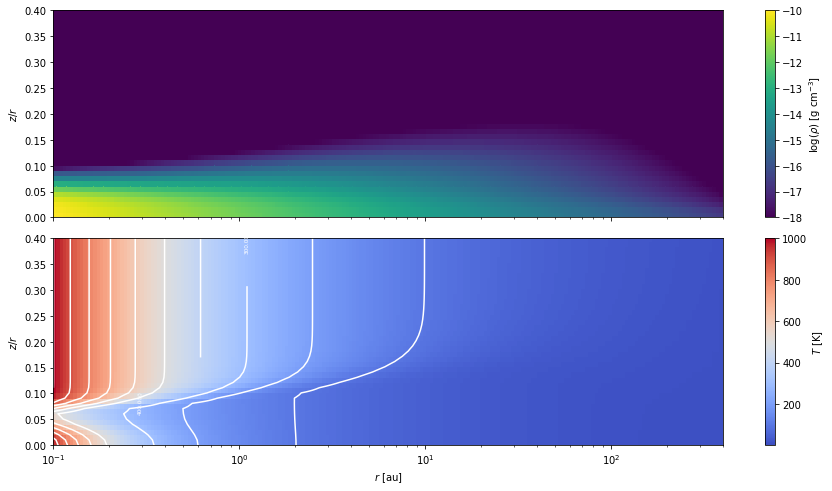

In [6]:
X1,Z1,rho1,T1,tau1,f = disklab.radmc3d.plot_vert_structure(disk2d)

In [13]:
#2D1

d.mean_opacity_planck[7:]    = movingaverage(d.mean_opacity_planck,10)[7:]
d.mean_opacity_rosseland[7:] = movingaverage(d.mean_opacity_rosseland,10)[7:]

for iter in range(100):
    d.compute_hsurf()
    d.compute_flareindex()
    d.compute_flareangle_from_flareindex(inclrstar=True)
    d.compute_disktmid(keeptvisc=False)
    d.compute_cs_and_hp()

disk2d = disklab.Disk2D(disk=d, zrmax=zrmax,
                        meanopacitymodel=d.meanopacitymodel, nz=100)

# snippet vertstruc 2d_1
for vert in disk2d.verts:
    vert.iterate_vertical_structure()
disk2d.radial_raytrace()
for vert in disk2d.verts:
    vert.solve_vert_rad_diffusion()
    vert.tgas = (vert.tgas**4 + 10**4)**(1/4)
    for dust in vert.dust:
        dust.compute_settling_mixing_equilibrium()


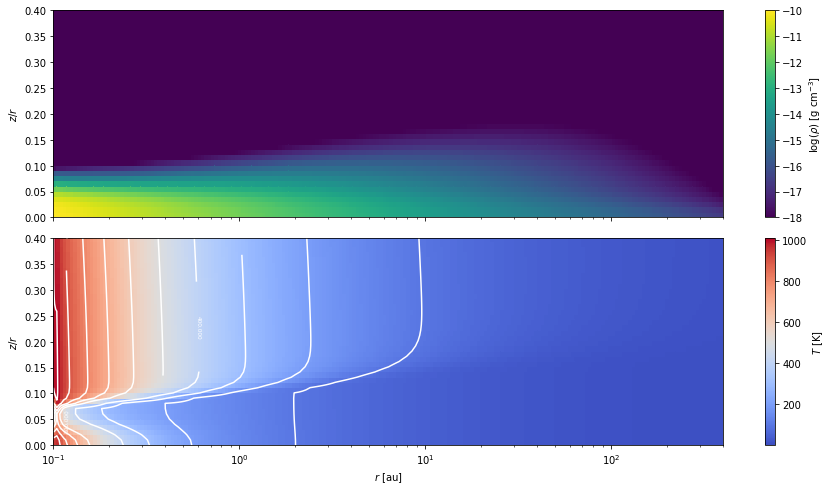

In [14]:
X2,Z2,rho2,T2,tau2,f = disklab.radmc3d.plot_vert_structure(disk2d)

In [25]:
#2D2
d.flang = np.ones(len(d.r))*d.flang

disk2d = disklab.Disk2D(disk=d, zrmax=zrmax, meanopacitymodel=d.meanopacitymodel, nz=100)

tgas_del   = np.array([])
rhogas_del = np.array([])
maxiter = 5

for vert in disk2d.verts:
    vert.compute_mean_opacity()
    vert.iterate_vertical_structure()

for iter in range(maxiter):
    tgas_del_iter   = 0
    rhogas_del_iter = 0
    disk2d_previous = copy.deepcopy(disk2d)
    for vert in disk2d.verts:
        vert.compute_mean_opacity()
    disk2d.radial_raytrace()
    #disk2d.setup_spherical_coordinate_system()
    disk2d.solve_2d_rad_diffusion(thist=True, simplecoordtrans=True)
    for slice in range(len(disk2d.verts)):
        tgas_del_vert   = np.sum((disk2d_previous.verts[slice].tgas - disk2d.verts[slice].tgas)**2)
        tgas_del_iter   = tgas_del_iter + tgas_del_vert
    #for vert_previous, vert in zip(disk2d_previous.verts, disk2d.verts):
    #    vert.tgas = 0.6 * vert_previous.tgas + 0.4 * vert.tgas
    for vert in disk2d.verts:
        vert_previous = copy.deepcopy(vert)
        vert.compute_rhogas_hydrostatic()
        rhogas_del_vert = np.sum((vert_previous.rhogas - vert.rhogas)**2)
        rhogas_del_iter = rhogas_del_iter + rhogas_del_vert
        for dust in vert.dust:
            dust_previous = copy.deepcopy(dust)
            dust.compute_settling_mixing_equilibrium()
            dust.rho = (dust_previous.rho + 0.4 * dust.rho) * np.sum(dust.rho * vert.dz) / np.sum((dust_previous.rho + 0.4*dust.rho) * vert.dz)
        vert.tgas = (vert.tgas**4 + 10**4)**(1/4)
    tgas_del   = np.append(tgas_del, tgas_del_iter)
    rhogas_del = np.append(rhogas_del, rhogas_del_iter)
 


  Nr of iter linear solver: 1905. Flux limiter iteration:  0. Error = 3.0717138636630237
  Nr of iter linear solver: 1098. Flux limiter iteration:  1. Error = 0.720637015012096
  Nr of iter linear solver: 1081. Flux limiter iteration:  2. Error = 0.5121854660750245
  Nr of iter linear solver: 1074. Flux limiter iteration:  3. Error = 0.23956954877101477
  Nr of iter linear solver: 1080. Flux limiter iteration:  4. Error = 0.04699448842251153
  Nr of iter linear solver: 1038. Flux limiter iteration:  5. Error = 0.03166580527522034
  Nr of iter linear solver: 1052. Flux limiter iteration:  6. Error = 0.02024485584709268
  Nr of iter linear solver: 1039. Flux limiter iteration:  7. Error = 0.01395208016531535
  Nr of iter linear solver: 1066. Flux limiter iteration:  8. Error = 0.01191004425553599
  Nr of iter linear solver: 1068. Flux limiter iteration:  9. Error = 0.009919195804578118
  Nr of iter linear solver: 1049. Flux limiter iteration: 10. Error = 0.008236095491550466
  Nr of iter

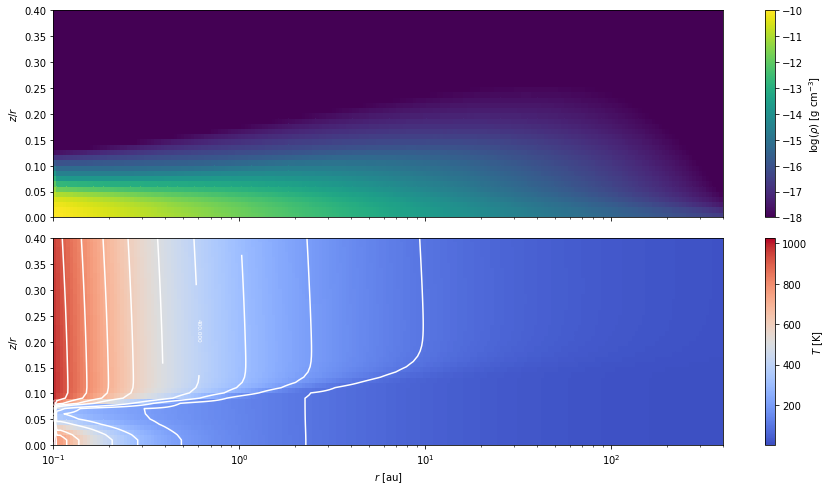

In [26]:
X3,Z3,rho3,T3,tau3,f = disklab.radmc3d.plot_vert_structure(disk2d)

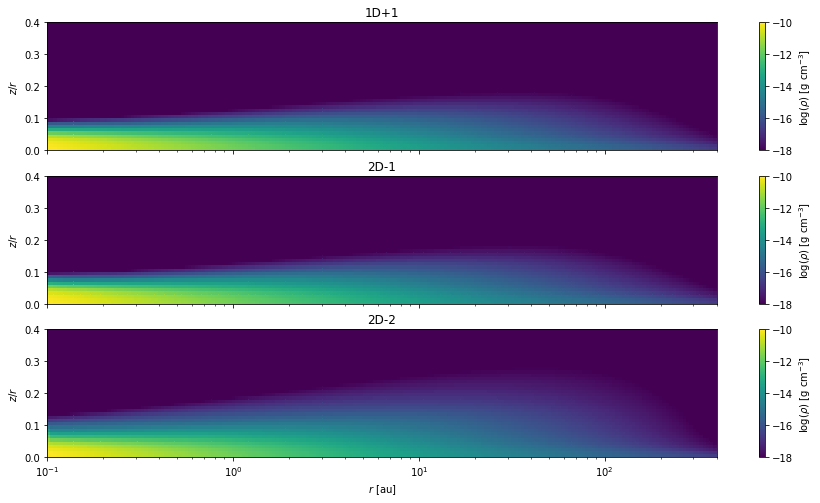

In [96]:
# PLOTTING

f, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True, sharey=True)

# 1d+1

vmax = np.ceil(np.log10(rho1.sum(-1).max()))
cc = axs[0].pcolormesh(X1 / au, Z1 / X1, np.log10(rho1.sum(-1) + 1e-100),
                       vmin=vmax - 8, vmax=vmax)  # gist_heat_r
axs[0].title.set_text('1D+1')
cb = plt.colorbar(cc, ax=axs[0])
cb.set_label(r'$\log(\rho)$ [g cm$^{-3}$]')

# 2d-1

vmax = np.ceil(np.log10(rho2.sum(-1).max()))
cc = axs[1].pcolormesh(X2 / au, Z2 / X2, np.log10(rho2.sum(-1) + 1e-100),
                       vmin=vmax - 8, vmax=vmax)  # gist_heat_r
axs[1].title.set_text('2D-1')
cb = plt.colorbar(cc, ax=axs[1])
cb.set_label(r'$\log(\rho)$ [g cm$^{-3}$]')

# 2d2

vmax = np.ceil(np.log10(rho3.sum(-1).max()))
cc = axs[2].pcolormesh(X3 / au, Z3 / X3, np.log10(rho3.sum(-1) + 1e-100),
                       vmin=vmax - 8, vmax=vmax)  # gist_heat_r
axs[2].title.set_text('2D-2')
cb = plt.colorbar(cc, ax=axs[2])
cb.set_label(r'$\log(\rho)$ [g cm$^{-3}$]')

# labels

for ax in axs:
    ax.set_ylabel('$z/r$')
ax.set_xlabel('$r$ [au]')
ax.set_ylim(0, 0.4)
ax.set_xscale('log')
f.subplots_adjust(hspace=0.2, wspace=0.05)

#f.savefig('Vertical_structures_24Feb.png')

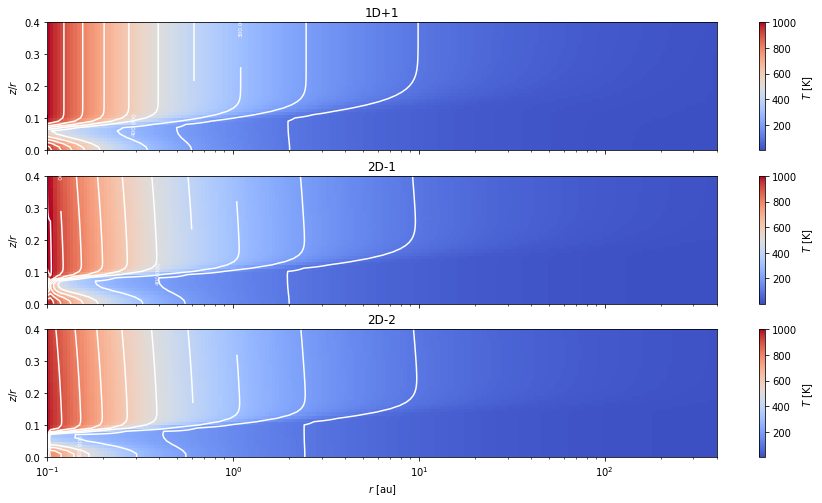

In [90]:
# PLOTTING

f, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True, sharey=True)

# 1d+1

vmax = np.ceil(T1.max())
cc = axs[0].pcolormesh(X1 / au, Z1 / X1, T1, vmin=1,
                       vmax=vmax, cmap='coolwarm')  # gist_heat_r
axs[0].title.set_text('1D+1')
cb = plt.colorbar(cc, ax=axs[0])
cb.set_label(r'$T$ [K]')

c = axs[0].contour(X1 / au, Z1 / X1, T1, 10, colors='w')
plt.clabel(c, inline=1, fontsize='xx-small')

# 2d-1

vmax = np.ceil(T1.max())
cc = axs[1].pcolormesh(X2 / au, Z2 / X2, T2, vmin=1,
                       vmax=vmax, cmap='coolwarm')  # gist_heat_r
axs[1].title.set_text('2D-1')
cb = plt.colorbar(cc, ax=axs[1])
cb.set_label(r'$T$ [K]')

c = axs[1].contour(X2 / au, Z2 / X2, T2, 10, colors='w')
plt.clabel(c, inline=1, fontsize='xx-small')

# 2d2

vmax = np.ceil(T1.max())
cc = axs[2].pcolormesh(X3 / au, Z3 / X3, T3, vmin=1,
                       vmax=vmax, cmap='coolwarm')  # gist_heat_r
axs[2].title.set_text('2D-2')
cb = plt.colorbar(cc, ax=axs[2])
cb.set_label(r'$T$ [K]')

c = axs[2].contour(X3 / au, Z3 / X3, T3, 10, colors='w')
plt.clabel(c, inline=1, fontsize='xx-small')

# labels

for ax in axs:
    ax.set_ylabel('$z/r$')
ax.set_xlabel('$r$ [au]')
ax.set_ylim(0, 0.4)
ax.set_xscale('log')
f.subplots_adjust(hspace=0.2, wspace=0.05)

f.savefig('temperature_profiles_24Feb.png')

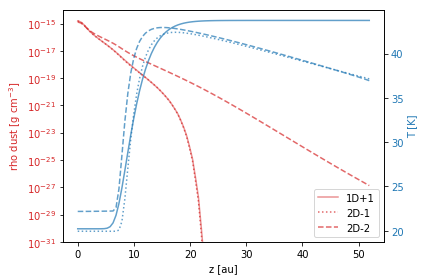

In [49]:
x = 150

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('z [au]')
ax1.set_ylabel('rho dust [g cm$^{-3}$]', color=color)
ax1.plot(Z1[x]/au, rho1.sum(-1)[x] ,color=color, alpha=0.5, label = '1D+1')
ax1.plot(Z2[x]/au, rho2.sum(-1)[x], linestyle = 'dotted', color=color, alpha=0.7, label = '2D-1')
ax1.plot(Z3[x]/au, rho3.sum(-1)[x], linestyle = 'dashed',  color=color, alpha=0.7, label = '2D-2')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')
ax1.set_ylim(1e-31,1e-14)
ax1.legend(loc= 'lower right')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('T [K]', color=color)  # we already handled the x-label with ax1
ax2.plot(Z1[x]/au, T1[x], color=color, alpha=0.7)
ax2.plot(Z2[x]/au, T2[x], linestyle = 'dotted', color=color, alpha=0.7)
ax2.plot(Z3[x]/au, T3[x], linestyle = 'dashed', color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('temp_dens_r_51au_ylogranged_6Mar.png', dpi=300)

In [54]:
T1

array([[ 955.01476987,  928.6322748 ,  853.21185955, ..., 1000.71549034,
        1000.71549034, 1000.71549034],
       [ 915.1193012 ,  889.98175842,  818.22390254, ...,  979.68655726,
         979.68655726,  979.68655726],
       [ 877.04208827,  853.09965748,  784.85667515, ...,  959.11642084,
         959.11642084,  959.11642084],
       ...,
       [  10.26908197,   10.29465723,   10.33510649, ...,   16.823993  ,
          16.82411688,   16.824202  ],
       [  10.06620673,   10.06636513,   10.06667087, ...,   16.50768873,
          16.50806406,   16.50832242],
       [  10.06001602,   10.06034057,   10.06094518, ...,   16.213961  ,
          16.21434861,   16.2146159 ]])

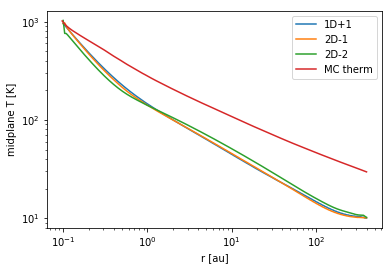

In [102]:
plt.plot(X1[:,0]/au, T1[:,0], label='1D+1' )
plt.plot(X2[:,0]/au, T2[:,0], label='2D-1' )
plt.plot(X3[:,0]/au, T3[:,0], label='2D-2' )
plt.plot(radmc_grid.r/ au,radmc_data.temp[:,0].reshape((209, 20))[:,1], label='MC therm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [au]')
plt.ylabel('midplane T [K]')
plt.legend()
#plt.savefig('midplane_temp_linear_6Mar.png', dpi=300)

In [61]:
X1

array([[1.49598000e+12, 1.49598000e+12, 1.49598000e+12, ...,
        1.49598000e+12, 1.49598000e+12, 1.49598000e+12],
       [1.55964800e+12, 1.55964800e+12, 1.55964800e+12, ...,
        1.55964800e+12, 1.55964800e+12, 1.55964800e+12],
       [1.62602566e+12, 1.62602566e+12, 1.62602566e+12, ...,
        1.62602566e+12, 1.62602566e+12, 1.62602566e+12],
       ...,
       [5.50534032e+15, 5.50534032e+15, 5.50534032e+15, ...,
        5.50534032e+15, 5.50534032e+15, 5.50534032e+15],
       [5.73964425e+15, 5.73964425e+15, 5.73964425e+15, ...,
        5.73964425e+15, 5.73964425e+15, 5.73964425e+15],
       [5.98392000e+15, 5.98392000e+15, 5.98392000e+15, ...,
        5.98392000e+15, 5.98392000e+15, 5.98392000e+15]])

In [80]:
radmc_data.temp[:,0].shape

(209, 1, 20)

In [28]:
!rm dustkappa_*.inp

In [27]:
# Assign the radmc3d data
rmcd = disklab.radmc3d.get_radmc3d_arrays(disk2d, showplots=False)

# nphi = rmcd['nphi']
ri = rmcd['ri']
thetai = rmcd['thetai']
phii = rmcd['phii']
nr = rmcd['nr']
# nth = rmcd['nth']
# nphi = rmcd['nphi']
rho = rmcd['rho']
rmcd_temp = rmcd['temp']

# Define the wavelength grid for the radiative transfer

nlam = 200
lam = np.logspace(-5, 1, nlam)
lam_mic = lam*1e4

# Write the `RADMC3D` input

radmc3d.write_stars_input(d, lam_mic)
radmc3d.write_grid(ri, thetai, phii, mirror=False)
#radmc3d.write_dust_density(rmcd_temp, fname = 'dust_temperature.dat', mirror=False) # writes out the temperature
radmc3d.write_dust_density(rho, mirror=False)
radmc3d.write_wavelength_micron(lam_mic)
radmc3d.write_opacity(disk2d)
radmc3d.write_radmc3d_input(
    {'scattering_mode': 5, 'scattering_mode_max': 5, 'nphot': 10000000})

In [33]:
%%time
radmc3d.radmc3d('mctherm setthreads 4')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

In [50]:
radmc_grid = radmc3d.read_amr_grid()
radmc_data = radmc3d.read_data(dtemp=True, ddens=True)

#radmc_data.temp = (radmc_data.temp**4 + 10**4)**(1/4)

#radmc_data.temp = radmc_data.temp.reshape((209, 200, 20))

#radmc3d.write_dust_density(radmc_data.temp, fname = 'dust_temperature.dat', mirror=False) # writes out the temperature


In [281]:
lam_obs = 0.125
rd = 250 * au
radmc3d.radmc3d(
    f'image incl 47.5 posang -144.4 npix 500 lambda {lam_obs * 1e4} sizeau {4*rd/au} secondorder  setthreads 1')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

In [282]:
im = radmc3d.read_image()

Text(0, 0.5, 'y [au]')

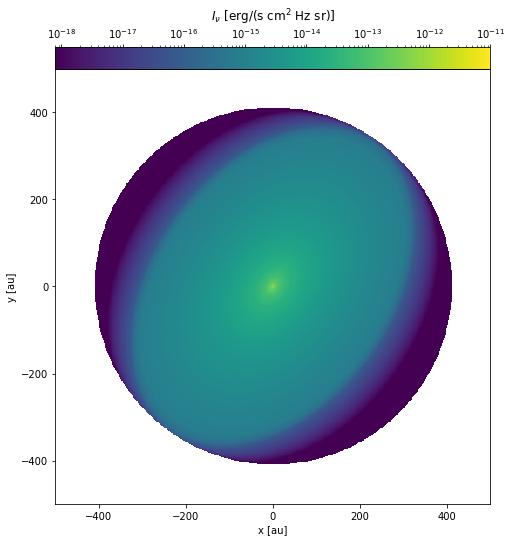

In [283]:
from matplotlib.colors import LogNorm

#vmin_arr = [1e-17, 4.7e-15]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect(1)
vmax = 0.5 * im.image.max()
vmin = 5e-16
cc   = ax.pcolormesh(im.x / au, im.y / au, im.image, norm=LogNorm(), vmax=1e-11 ,vmin=8e-19, rasterized=True)

pos = ax.get_position()
cb = plt.colorbar(cc, orientation='horizontal')
cb.ax.set_position([pos.x0, pos.y1, pos.width, 0.05 * pos.height])
ax.set_position([pos.x0, pos.y0,pos.width, pos.height])
cb.ax.xaxis.tick_top()
cb.ax.set_title(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')
ax.set_xlabel('x [au]')
ax.set_ylabel('y [au]')
#f.savefig('image_1250micron_1+1d_26thFeb.png')

In [284]:
radial_profile = []
radial = []
for x, y in zip(range(0,251,1),range(249,500,1)):
    radial_profile.append(im.image[y][int(round(249+x*np.tan(0.6213372)))])
    radial.append(np.sqrt((im.x[int(round(249+x*np.tan(0.6213372)))]/au)**2 + (im.y[y]/au)**2) )

In [207]:
radial_profile_high_mass = copy.deepcopy(radial_profile)

In [219]:
radial_profile_low_mass = copy.deepcopy(radial_profile)

In [285]:
radial_profile_small_dust = copy.deepcopy(radial_profile)

In [167]:
radial_profile_1d1 = copy.deepcopy(radial_profile)

In [23]:
radial_profile_2d1 = copy.deepcopy(radial_profile)

In [37]:
radial_profile_2d2 = copy.deepcopy(radial_profile)

In [84]:
radial_profile_mc = copy.deepcopy(radial_profile)

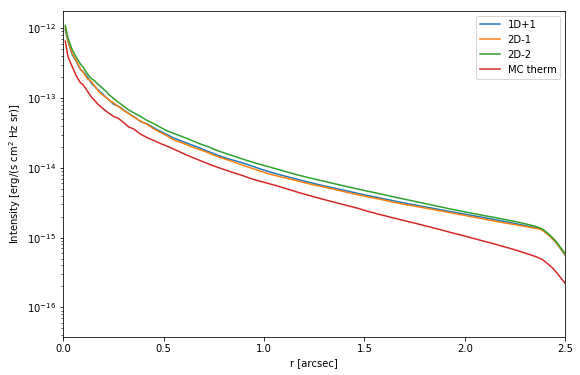

In [92]:
f, ax = plt.subplots(figsize=(9, 6))

ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile_1d1), label='1D+1')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile_2d1), label='2D-1')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile_2d2), label='2D-2')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile_mc), label='MC therm')

ax.set_xscale('linear')
ax.set_xlim(0, 2.5)
ax.set_ylabel('Intensity [erg/(s cm$^2$ Hz sr)]')
ax.set_xlabel('r [arcsec]')
#ax.set_ylim(1e-16, 3e-12)
ax.legend()
plt.savefig('radial_profile_temp_test_24Feb.png', dpi=300);

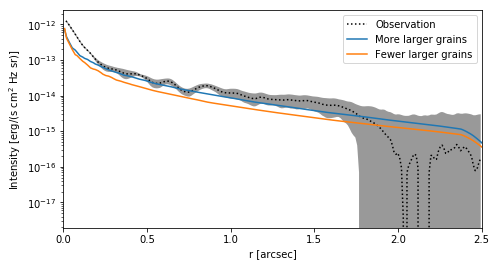

In [289]:
f, ax = plt.subplots(figsize=(7.5, 4))
ax.loglog(x_arcsec, profile, 'k:', label='Observation')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile_high_mass), label='More larger grains')
ax.loglog(np.asarray(radial)/158,np.asarray(radial_profile_small_dust), label='Fewer larger grains')



ax.fill_between(x_arcsec, profile - profile_err, y2=profile + profile_err, facecolor='0.6')
ax.set_xscale('linear')
ax.set_xlim(0, 2.5)
ax.set_ylabel('Intensity [erg/(s cm$^2$ Hz sr)]')
ax.set_xlabel('r [arcsec]')
#ax.set_ylim(1e-16, 3e-12)
ax.legend()
plt.savefig('radial_profile_mm_size_test_27Feb.png', dpi=300);

## Scattering

In the following sections the full scattering image of the disk has been calculated. In order to do this 

1) Use dsharp_opac.get_opacities() function with the appropriate arguments. This gives a dictionary output of different optical parameters

2) Use calculate_mueller_matrix() function to calculate the scattering matrix elements

3) Add these to the previously calculated dictionary

4) Treat forward scattering as no scattering and update values of the scatmat matrix accordingly. This is done because this package (and RADMC as well) looks at the matrix elements of the full scattering and then calculates the values of some of the other non-angle optical values like 'g' and 'k_scat' and so on. Since the data is discrete and the angle values are not fine grained enough, there is a discrepancy in the calculated values and the values from the package. Here a cut of 5 degrees has been used and this works. This cutoff value could be changed by changing the chopforward variable

5) Write them out using the write_radmc3d_scatmat_file() function

In [34]:
oc, rho_s = opacity.get_dsharp_mix()

#a   = np.logspace(-5, -1, 100)
m   = 4 * np.pi / 3 * rho_s * agrains**3
nlam = 200
lam = np.logspace(-5,1,nlam)

res = opacity.get_opacities(agrains, lam, rho_s, oc, extrapolate_large_grains=False, n_angle=100)

k_abs = res['k_abs']
k_sca = res['k_sca']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']
g     = res['g']

# index where theta = 90 degree

i90 = theta.searchsorted(90)

zscat = opacity.calculate_mueller_matrix(lam, m, S1, S2, theta=theta, k_sca=k_sca)['zscat']

chopforward = 5
zscat_nochop = np.zeros((len(agrains) ,nlam, len(theta), 6))
kscat_nochop = np.zeros((len(agrains), nlam))
g_nochop     = np.zeros((len(agrains), nlam))

for grain in range(len(agrains)):
    for i in range(nlam):
        #
        #
        # Now loop over the grain sizes
        #
        if chopforward > 0:
            iang = np.where(theta < chopforward)
            if theta[0] == 0.0:
                iiang = np.max(iang) + 1
            else:
                iiang = np.min(iang) - 1
            zscat_nochop[grain, i, :, :] = zscat[grain, i, :, :]  # Backup
            kscat_nochop[grain, i] = k_sca[grain, i]      # Backup
            g_nochop[grain, i]     = g[grain, i]
            zscat[grain, i, iang, 0] = zscat[grain, i, iiang, 0]
            zscat[grain, i, iang, 1] = zscat[grain, i, iiang, 1]
            zscat[grain, i, iang, 2] = zscat[grain, i, iiang, 2]
            zscat[grain, i, iang, 3] = zscat[grain, i, iiang, 3]
            zscat[grain, i, iang, 4] = zscat[grain, i, iiang, 4]
            zscat[grain, i, iang, 5] = zscat[grain, i, iiang, 5]
            mu = np.cos(theta * np.pi / 180.)
            dmu = np.abs(mu[1:len(theta)] - mu[0:(len(theta) - 1)])
            zav = 0.5 * (zscat[grain, i, 1:len(theta), 0] + zscat[grain, i, 0:len(theta)-1, 0])
            dum = 0.5 * zav * dmu
            sum = dum.sum() * 4 * np.pi
            k_sca[grain, i] = sum

            mu_2 = 0.5 * (np.cos(theta[1:len(theta)] * np.pi / 180.) + np.cos(theta[0:len(theta)-1] * np.pi / 180.))
            P_mu = 0.5 * ((2*np.pi*zscat[grain, i, 1:len(theta), 0] / k_sca[grain, i]) + (2*np.pi*zscat[grain, i, 0:len(theta)-1, 0] / k_sca[grain, i]))
            g[grain,i] = np.sum(P_mu*mu_2*dmu)

opacity_dict = {'a':agrains,
        'lam':lam,
        'theta':theta,
        'rho_s':rho_s,
        'k_abs':k_abs,
        'k_sca':k_sca,
        'g': g,
        'zscat':zscat}

# add the scattering matrix to the dictionary
res['zscat'] = zscat

for filename in glob.glob(os.path.join( "dustkappa_*.inp")):
    os.remove(filename)
    
    

for x in agrains:
    i_grain = agrains.searchsorted(x)
    opacity.write_radmc3d_scatmat_file(i_grain, opacity_dict, f'{i_grain}')

def write(fid, *args, **kwargs):
    fmt = kwargs.pop('fmt', '')
    sep = kwargs.pop('sep', ' ')
    fid.write(sep.join([('{' + fmt + '}').format(a) for a in args]) + '\n')


with open(os.path.join( 'dustopac.inp'), 'w') as f:
    write(f, '2               Format number of this file')
    write(f, '{}              Nr of dust species'.format(len(agrains)))

    for x in agrains:
        i_grain = agrains.searchsorted(x)
        write(f, '============================================================================')
        write(f, '10               Way in which this dust species is read')
        write(f, '0               0=Thermal grain')
        write(f, '{}              Extension of name of dustscatmat_***.inp file'.format(i_grain))

    write(f, '----------------------------------------------------------------------------')


rd = 250 * au
#radmc3d.radmc3d(f'image incl 47.5 posang -54.4 npix 500 lambda 1.65 sizeau 500 setthreads 4')
radmc3d.radmc3d(f'image incl 47.5 posang 54.4 npix 500 lambda 1.65 sizeau 1000 setthreads 4')


#data = analyze.readData(dtemp=True, binary = False)
im = image.readImage(os.path.join('image.out'))
im.writeFits(os.path.join('image.fits'), dpc=158., coord='15h56m09.17658s -37d56m06.1193s')

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
Mie ... Done!
>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D r

In [35]:
image_name = 'image.fits'

sim_data = imagecube(image_name, clip=3)

sim_x, sim_y, sim_dy = sim_data.radial_profile(inc=47.4, PA=144.6, z0=0.2, psi=1.27)

sim_profile     = (sim_y * u.Jy / sim_data.beam_area_str).cgs.value
sim_profile_err = (sim_dy * u.Jy / sim_data.beam_area_str).cgs.value

Text(0, 0.5, 'y [as]')

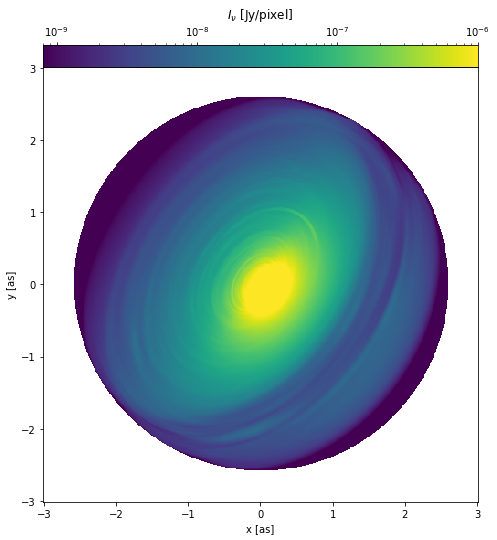

In [31]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect(1)

cc   = ax.pcolormesh(np.flip(sim_data.xaxis),sim_data.yaxis, sim_data.data, norm=LogNorm(), vmax=1e-6, vmin=8e-10, rasterized=True)

pos = ax.get_position()
cb = plt.colorbar(cc, orientation='horizontal')
cb.ax.set_position([pos.x0, pos.y1, pos.width, 0.05 * pos.height])
ax.set_position([pos.x0, pos.y0,pos.width, pos.height])
cb.ax.xaxis.tick_top()
cb.ax.set_title(r'$I_\nu$ [Jy/pixel]')
ax.set_xlabel('x [as]')
ax.set_ylabel('y [as]')
#f.savefig('scattered_light_image_26thFeb.png')

Text(0, 0.5, 'y [as]')

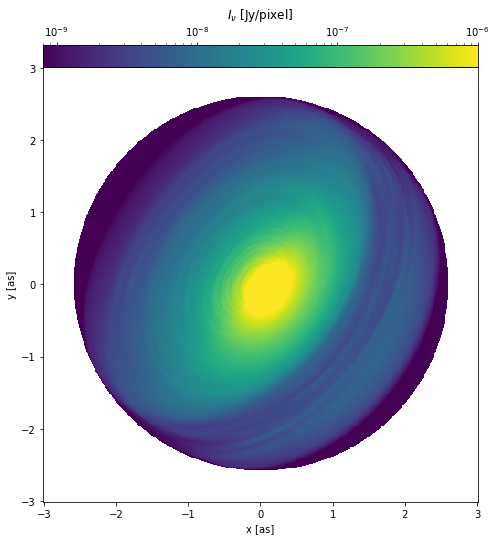

In [36]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect(1)

cc   = ax.pcolormesh(np.flip(sim_data.xaxis),sim_data.yaxis, sim_data.data, norm=LogNorm(), vmax=1e-6, vmin=8e-10, rasterized=True)

pos = ax.get_position()
cb = plt.colorbar(cc, orientation='horizontal')
cb.ax.set_position([pos.x0, pos.y1, pos.width, 0.05 * pos.height])
ax.set_position([pos.x0, pos.y0,pos.width, pos.height])
cb.ax.xaxis.tick_top()
cb.ax.set_title(r'$I_\nu$ [Jy/pixel]')
ax.set_xlabel('x [as]')
ax.set_ylabel('y [as]')
#f.savefig('scattered_light_image_26thFeb.png')

In [10]:
sim_profile_high_mass = copy.deepcopy(sim_profile)

In [23]:
sim_profile_low_mass = copy.deepcopy(sim_profile)

In [21]:
sim_profile_1d1 = copy.deepcopy(sim_profile)

In [24]:
sim_profile_2d1 = copy.deepcopy(sim_profile)

In [32]:
sim_profile_2d2 = copy.deepcopy(sim_profile)

In [37]:
sim_profile_mc  = copy.deepcopy(sim_profile)

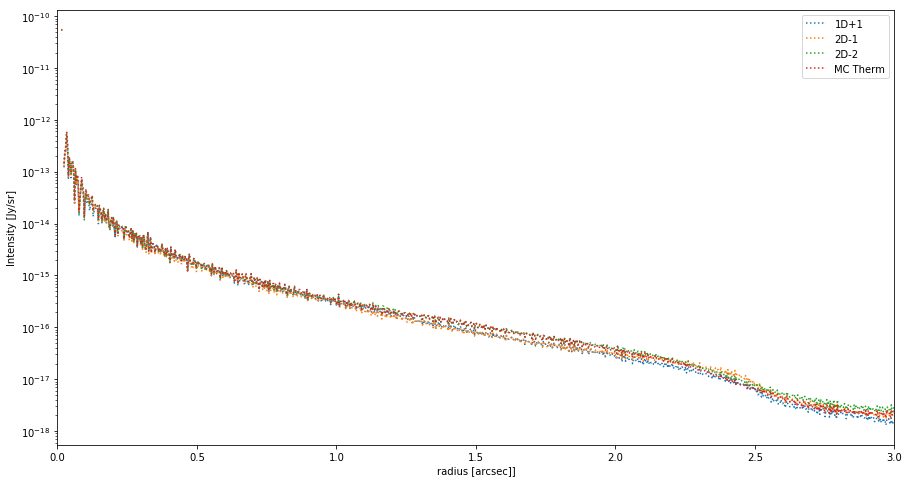

In [39]:
f, ax = plt.subplots(figsize=(15, 8))
ax.loglog(sim_x, sim_profile_1d1, ':', label='1D+1')
ax.loglog(sim_x, sim_profile_2d1, ':', label='2D-1')
ax.loglog(sim_x, sim_profile_2d2, ':', label='2D-2')
ax.loglog(sim_x, sim_profile_mc, ':', label='MC Therm')


ax.set_xscale('linear')
ax.set_xlim(0, 3)
ax.set_xlabel('radius [arcsec]]')
ax.set_ylabel('Intensity [Jy/sr]')
ax.legend();
plt.savefig('radial_profile_temp_test_scattered_6Mar.png', dpi=300);

In [42]:
disk   = 'IMLup'
#fname  = dh.get_datafile(disk)
fname  = 'Qphi_IMLup.fits'
PA     = dh.sources.loc[disk]['PA']
inc    = dh.sources.loc[disk]['inc']
d      = dh.sources.loc[disk]['distance [pc]']
T_star = 10.**dh.sources.loc[disk]['log T_eff/ K']
M_star = 10.**dh.sources.loc[disk]['log M_star/M_sun'] * c.M_sun.cgs.value
L_star = 10.**dh.sources.loc[disk]['log L_star/L_sun'] * c.L_sun.cgs.value
R_star = np.sqrt(L_star / (4 * np.pi * c.sigma_sb.cgs.value * T_star**4))

clip =3.0

# fix the header of the sphere image
hdulist = fits.open(fname)
hdu0 = hdulist[0]

hdu0.header['cdelt1'] = -3.405e-06
hdu0.header['cdelt2'] = 3.405e-06
hdu0.header['crpix1'] = hdu0.header['naxis1']//2+1
hdu0.header['crpix2'] = hdu0.header['naxis2']//2+1
hdu0.header['crval1'] = 0.0
hdu0.header['crval2'] = 0.0
hdu0.header['crval3'] = 1.65e-4
data = imagecube(hdulist, clip=clip)


x, y, dy = data.radial_profile(inc=inc, PA=PA, z0=0.2, psi=1.27)

profile = (y * u.Jy / data.beam_area_str).cgs.value
profile_err = (dy * u.Jy / data.beam_area_str).cgs.value

In [347]:
image_name = os.path.join( 'image_1d1_26Feb.fits')

sim_data = imagecube(image_name, clip=clip)


sim_x, sim_y, sim_dy = sim_data.radial_profile(inc=inc, z0=0.2, psi=1.27)

sim_profile     = (sim_y * u.Jy / sim_data.beam_area_str).cgs.value
sim_profile_err = (sim_dy * u.Jy / sim_data.beam_area_str).cgs.value

In [348]:
sim_profile = copy.deepcopy(sim_profile)

In [40]:
sim_profile_small_dust = copy.deepcopy(sim_profile)

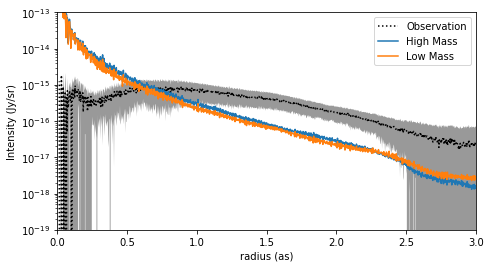

In [47]:
f, ax = plt.subplots(figsize=(7.5, 4))
ax.loglog(x, profile, 'k:', label='Observation')
ax.loglog(sim_x, sim_profile_high_mass,  label='High Mass')
ax.loglog(sim_x, sim_profile_low_mass,  label='Low Mass')


ax.fill_between(x, profile - profile_err, y2=profile + profile_err, facecolor='0.6')
ax.set_xscale('linear')
ax.set_xlim(0, 3)
ax.set_ylim(1e-19,1e-13 )
ax.set_xlabel('radius (as)')
ax.set_ylabel('Intensity (Jy/sr)')
ax.legend();
f.savefig('radial_profile_scattering_mass_test_6Mar.png',dpi=300)